## **ANALIZA CZYNNIKÓW WPŁYWAJĄCYCH NA ZAROBKI GRACZY NBA**

**Przedmiot:** Analiza danych w R i Python.  

**Cel projektu:** Określenie wpływu popularności, a efektywności gracza na jego zarobki.  

**Autorzy:** Szymon Chodun, Dominik Łukasiuk, Igor Korusiewicz.  



### **1. ISTALACJA NIEZBĘDNYCH PAKIETÓW**

In [ ]:
%%capture

#1.1 INSTALACJA PAKIETOW
%pip install pandas
%pip install matplotlib
%pip install seaborn
%pip install openpyxl
%pip install scikit-learn
%pip install numpy
%pip install scipy
%pip install statsmodels
%pip install jinja2

#1.2 IMPORT PAKIETOW
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from math import pi
from matplotlib.colors import LogNorm
import statsmodels.api as sm
import matplotlib.ticker as ticker
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from IPython.display import display, Markdown
from matplotlib.colors import LogNorm, LinearSegmentedColormap


### **2. IMPORT ORAZ PRZEKSZTAŁCANIE DANYCH**

In [ ]:
#DANE

#2.1 IMPORT DANYCH
data = pd.read_excel('data_NBA.xlsx')

#2.2 ZMIANA NAZWY ZMIENNEJ
data.rename(columns={'Salary': 'Pensja'}, inplace=True)

#2.3 ZMIANA TYPU DANYCH 
data_liczbowe = data.columns.difference(['Zawodnik', 'Zespół', 'Pozycja', 'Obserwujacy_mln'])
data[data_liczbowe] = data[data_liczbowe].apply(pd.to_numeric, errors='coerce')

#2.4 KONWERSJA ZMIENNEJ 'Obserwujacy_mln'
data['Obserwujacy_mln'] = data['Obserwujacy_mln'].replace('<1', 0.5)
data['Obserwujacy_mln'] = pd.to_numeric(data['Obserwujacy_mln'], errors='coerce')








Łączna liczba braków:
0


C:\Users\szymo\AppData\Local\Temp\ipykernel_19608\2854290931.py:18: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['Obserwujacy_mln'] = data['Obserwujacy_mln'].replace('<1', 0.5)


### **3. STRUKTURA DANYCH**

In [ ]:
# 3.1 SŁOWNIK ZMIENNYCH
opis_kolumn = {
    "Zawodnik": "Imie i nazwisko koszykarza",
    "Zespół": "Skrót nazwy drużyny (np. GSW)",
    "Wiek": "Wiek zawodnika (w latach)",
    "Mecze": "Liczba rozegranych spotkań",
    "Wygrane": "Liczba wygranych meczów",
    "Przegrane": "Liczba przegranych meczów",
    "Minuty_srednio": "Średnia minut na parkiecie",
    "Punkty_srednio": "Średnia punktów na mecz",
    "Celnerzuty_srednio": "Średnia celnych rzutów",
    "Rzuty_srednio": "Średnia oddanych rzutów",
    "Skuteczność_proc": "Skuteczność rzutów z gry",
    "Zbiorki_srednia": "Średnia zbiórek",
    "Asysty_srednio": "Średnia asyst",
    "Straty_srednio": "Średnia strat",
    "Przechwyty_srednia": "Średnia przechwytów",
    "Blok_srednia": "Średnia bloków",
    "Faul_srednio": "Średnia fauli",
    "Pensja": "Roczne wynagrodzenie (USD)",
    "Pozycja": "Pozycja na boisku",
    "Obserwujacy_mln": "Obserwujący na Instagramie (mln)"
}

df_opis = pd.DataFrame(list(opis_kolumn.items()), columns=['Nazwa Zmiennej', 'Definicja'])

display(Markdown("### **Słownik zmiennych**"))
display(
    df_opis.style
    .hide(axis='index')                            
    .set_properties(**{'text-align': 'left'})      
    .set_table_styles([dict(selector='th', props=[('text-align', 'left')])]) 
)

#3.2 TYP DANYCH (PO PRZEKSZTAŁCENIACH)
display(Markdown("### **Typy danych (po przekształceniach)**"))

df_types = data.dtypes.to_frame(name='Typ Danych').reset_index()
df_types.columns = ['Nazwa Kolumny', 'Typ Danych']

display(
    df_types.style
    .hide(axis='index')                            
    .set_properties(**{'text-align': 'left'})       
    .set_table_styles([dict(selector='th', props=[('text-align', 'left')])]) 
)

#3.3 WYMIARY ZBIORU DANYCH
display(Markdown(f"### **Wymiary zbioru danych:** `{data.shape[0]}` wierszy, `{data.shape[1]}` kolumn"))

#3.4 WERYFIKACJA BRAKÓW DANYCH
display(Markdown(f"### **Łączna liczba braków:** `{data.isnull().sum().sum()}`"))

#3.5 PODGLĄD DANYCH (HEAD)
display(Markdown("### **Podgląd danych (Pierwsze 5 wierszy)**"))


formatowanie = {
    'Pensja': '${:,.0f}',           
    'Skuteczność_proc': '{:.1f}%',  
    'Obserwujacy_mln': '{:.1f}M',   
    'Punkty_srednio': '{:.1f}',     
    'Minuty_srednio': '{:.1f}'
}


display(
    data.head()
    .style
    .format(formatowanie)           
    .hide(axis='index')             
    .set_properties(**{'border-color': 'lightgrey'}) 
)

#3.6 STATYSTKI OPISOWE
display(Markdown("### **Statystyki opisowe**"))
display(
    data.describe().round(2).style
    .format("{:,.2f}")              
)

### **Słownik zmiennych**

Nazwa Zmiennej,Definicja
Zawodnik,Imie i nazwisko koszykarza
Zespół,Skrót nazwy drużyny (np. GSW)
Wiek,Wiek zawodnika (w latach)
Mecze,Liczba rozegranych spotkań
Wygrane,Liczba wygranych meczów
Przegrane,Liczba przegranych meczów
Minuty_srednio,Średnia minut na parkiecie
Punkty_srednio,Średnia punktów na mecz
Celnerzuty_srednio,Średnia celnych rzutów
Rzuty_srednio,Średnia oddanych rzutów


### **Typy danych (po przekształceniach)**

Nazwa Kolumny,Typ Danych
Zawodnik,object
Zespół,object
Wiek,int64
Mecze,int64
Wygrane,int64
Przegrane,int64
Minuty_srednio,float64
Punkty_srednio,float64
Celnerzuty_srednio,float64
Rzuty_srednio,float64


### **Wymiary zbioru danych:** `468` wierszy, `20` kolumn

### **Łączna liczba braków:** `0`

### **Podgląd danych (Pierwsze 5 wierszy)**

Zawodnik,Zespół,Wiek,Mecze,Wygrane,Przegrane,Minuty_srednio,Punkty_srednio,Celnerzuty_srednio,Rzuty_srednio,Skuteczność_proc,Zbiorki_srednia,Asysty_srednio,Straty_srednio,Przechwyty_srednia,Blok_srednia,Faul_srednio,Pensja,Pozycja,Obserwujacy_mln
Stephen Curry,GSW,37,70,41,29,32.2,24.5,8.100000,18.000000,44.8%,4.400000,6.000000,2.900000,1.100000,0.400000,1.400000,"$55,761,216",Obronca,58.4M
Nikola Jokic,DEN,30,70,46,24,36.7,29.6,11.200000,19.500000,57.6%,12.700000,10.200000,3.300000,1.800000,0.600000,2.300000,"$51,415,938",Srodkowy,0.5M
Joel Embiid,PHI,31,19,8,11,30.2,23.8,7.400000,16.600000,44.4%,8.200000,4.500000,3.300000,0.700000,0.900000,2.200000,"$51,415,938",Srodkowy,7.2M
Kevin Durant,PHX,36,62,33,29,36.5,26.6,9.500000,18.100000,52.7%,6.000000,4.200000,3.100000,0.800000,1.200000,1.700000,"$51,179,021",Skrzydlowy,13.7M
Bradley Beal,PHX,32,53,22,31,32.1,17.0,6.500000,13.100000,49.7%,3.300000,3.700000,1.900000,1.100000,0.500000,2.600000,"$50,203,930",Obronca,1.4M


### **Statystyki opisowe**

,Wiek,Mecze,Wygrane,Przegrane,Minuty_srednio,Punkty_srednio,Celnerzuty_srednio,Rzuty_srednio,Skuteczność_proc,Zbiorki_srednia,Asysty_srednio,Straty_srednio,Przechwyty_srednia,Blok_srednia,Faul_srednio,Pensja,Obserwujacy_mln
count,468.00,468.00,468.00,468.00,468.00,468.00,468.00,468.00,468.00,468.00,468.00,468.00,468.00,468.00,468.00,468.00,468.00
mean,26.57,53.41,26.99,26.41,21.37,10.05,3.68,7.91,46.32,3.95,2.32,1.21,0.73,0.45,1.68,"10,801,724.36",1.62
std,4.50,20.14,14.43,12.69,8.92,6.56,2.34,4.89,8.18,2.41,1.86,0.83,0.41,0.42,0.70,"12,484,170.73",8.18
min,19.00,1.00,0.00,0.00,1.80,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,"113,055.00",0.50
25%,23.00,39.75,15.00,17.00,14.60,5.00,1.90,4.00,42.10,2.30,1.00,0.60,0.40,0.20,1.20,"2,092,344.00",0.50
50%,26.00,57.00,27.00,26.00,21.35,8.70,3.20,7.00,45.40,3.40,1.70,1.00,0.70,0.30,1.70,"5,197,760.00",0.50
75%,29.00,70.25,38.00,35.00,28.60,13.42,5.00,10.60,49.72,5.00,3.10,1.60,0.92,0.60,2.20,"13,117,477.50",0.50
max,40.00,82.00,64.00,64.00,37.70,32.70,11.80,21.80,79.80,13.90,11.60,4.70,3.00,3.80,3.50,"55,761,216.00",159.70


### **4. ANALIZA DANYCH**

In [90]:
#4.1 PRZYGOTOWANIE DANYCH DO ANALIZY
data['Obrona_Suma'] = data['Blok_srednia'] + data['Przechwyty_srednia']
data['Punkty_total'] = data['Punkty_srednio'] * data['Mecze']

data_valid = data[data['Punkty_total'] > 0].copy()
data['Koszt_za_punkt'] = data['Pensja'] / data_valid['Punkty_total'] 

cols_view = ['Zawodnik', 'Pensja', 'Obserwujacy_mln', 'Punkty_srednio']

def pokaz_top_rankingi(df, kategorie_dict, kolumny_widok):
    for kolumna, tytul in kategorie_dict.items():
        display(Markdown(f"### {tytul}"))
        display(df.nlargest(3, kolumna)[kolumny_widok].style.format({'Pensja': '${:,.0f}'}).hide(axis='index'))

#4.2 ANALIZA TOP 3
display(Markdown("## Top 3 zawodników w różnych kategoriach"))

kategorie = {
    'Pensja': 'Największe zarobki',
    'Obserwujacy_mln': 'Najwięcej obserwujących',
    'Punkty_srednio': 'Najwięcej punktów średnio',
    'Minuty_srednio': 'Najwięcej minut na boisku',
    'Skuteczność_proc': 'Najlepsza skuteczność (%)',
    'Obrona_Suma': 'Najlepsi obrońcy (Bloki + Przechwyty)'
}

pokaz_top_rankingi(data, kategorie, cols_view)

#4.3 ANALIZA EFEKTYWNOŚCI
display(Markdown("## Najbardziej i najmniej opłacalni zawodnicy"))
display(Markdown("### Najbardziej opłacalni (Najmniej $ za punkt):"))
display(data.nsmallest(5, 'Koszt_za_punkt')[['Zawodnik', 'Zespół', 'Pensja', 'Koszt_za_punkt']])

display(Markdown("### Najbardziej przepłaceni (Najwięcej $ za punkt):"))
display(data.nlargest(5, 'Koszt_za_punkt')[['Zawodnik', 'Zespół', 'Pensja', 'Koszt_za_punkt']])

#4.4 NAJLEPIEJ PŁACĄCE ZESPOŁY
display(Markdown("## Najlepiej płacące zespoły"))
top_zespoly = data.groupby('Zespół')['Pensja'].mean().sort_values(ascending=False).head(8).reset_index()
display(top_zespoly.style.format({'Pensja': '${:,.2f}'}))

## Top 3 zawodników w różnych kategoriach

### Największe zarobki

Zawodnik,Pensja,Obserwujacy_mln,Punkty_srednio
Stephen Curry,"$55,761,216",58.400000,24.500000
Nikola Jokic,"$51,415,938",0.500000,29.600000
Joel Embiid,"$51,415,938",7.200000,23.800000


### Najwięcej obserwujących

Zawodnik,Pensja,Obserwujacy_mln,Punkty_srednio
LeBron James,"$48,728,845",159.700000,24.400000
Stephen Curry,"$55,761,216",58.400000,24.500000
Russell Westbrook,"$3,303,771",22.600000,13.300000


### Najwięcej punktów średnio

Zawodnik,Pensja,Obserwujacy_mln,Punkty_srednio
Shai Gilgeous-Alexander,"$35,859,950",4.800000,32.700000
Giannis Antetokounmpo,"$48,787,676",16.000000,30.400000
Nikola Jokic,"$51,415,938",0.500000,29.600000


### Najwięcej minut na boisku

Zawodnik,Pensja,Obserwujacy_mln,Punkty_srednio
Tyrese Maxey,"$35,147,000",0.500000,26.300000
Josh Hart,"$18,144,000",0.500000,13.600000
Devin Booker,"$49,205,800",5.500000,25.600000


### Najlepsza skuteczność (%)

Zawodnik,Pensja,Obserwujacy_mln,Punkty_srednio
Kai Jones,"$2,196,970",0.500000,5.000000
Jaxson Hayes,"$2,463,946",0.500000,6.800000
Jarrett Allen,"$20,000,000",0.500000,13.500000


### Najlepsi obrońcy (Bloki + Przechwyty)

Zawodnik,Pensja,Obserwujacy_mln,Punkty_srednio
Victor Wembanyama,"$12,768,960",5.100000,24.300000
Dyson Daniels,"$6,059,520",0.500000,14.100000
Anthony Davis,"$43,219,440",6.900000,24.700000


## Najbardziej i najmniej opłacalni zawodnicy

### Najbardziej opłacalni (Najmniej $ za punkt):

,Zawodnik,Zespół,Pensja,Koszt_za_punkt
460,Justin Edwards,PHI,425619,957.74
467,Drew Timme,BKN,113055,"1,038.15"
466,Isaac Jones,SAC,152957,"1,124.68"
448,Tyrese Martin,BKN,635853,"1,218.11"
457,Quinten Post,GSW,438920,"1,290.18"


### Najbardziej przepłaceni (Najwięcej $ za punkt):

,Zawodnik,Zespół,Pensja,Koszt_za_punkt
223,Taylor Hendricks,UTA,5848680,"414,800.00"
329,James Wiseman,IND,2237691,"372,948.50"
388,PJ Dozier,MIN,2087519,"289,933.19"
389,James Johnson,IND,2087519,"248,514.17"
124,De'Anthony Melton,BKN,12822000,"207,475.73"


## Najlepiej płacące zespoły

,Zespół,Pensja
0,PHX,"$14,067,411.20"
1,BOS,"$13,953,426.43"
2,DEN,"$12,822,048.21"
3,GSW,"$12,604,449.29"
4,CLE,"$12,089,678.86"
5,MIN,"$12,085,974.41"
6,NYK,"$11,920,968.50"
7,DAL,"$11,612,571.40"


### **5. ROZKŁAD DANYCH**

## **Rozkład zmiennych (Wykresy)**

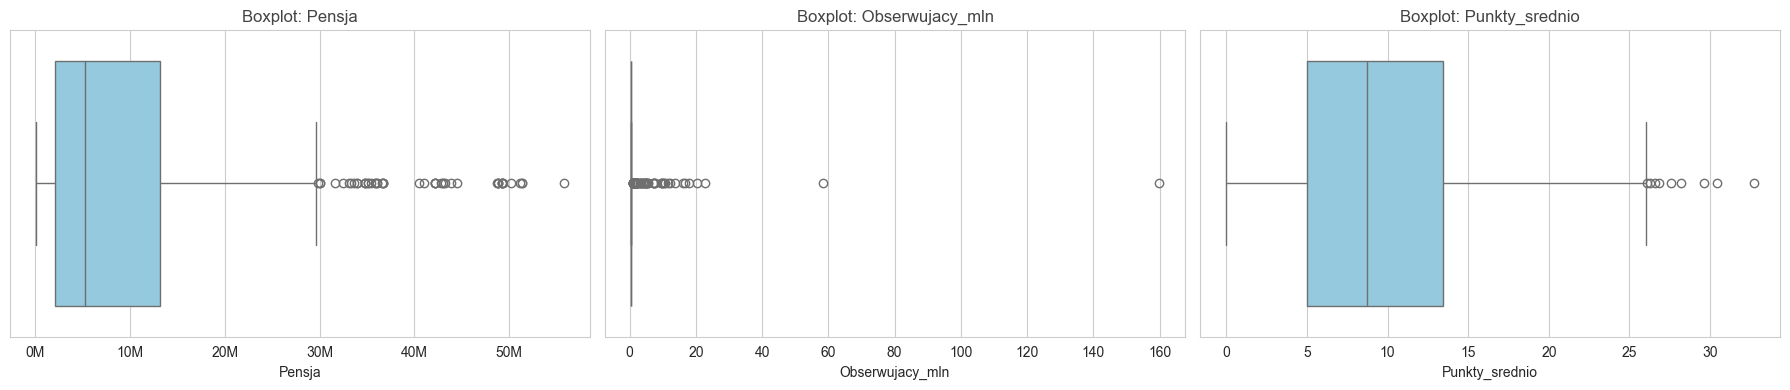

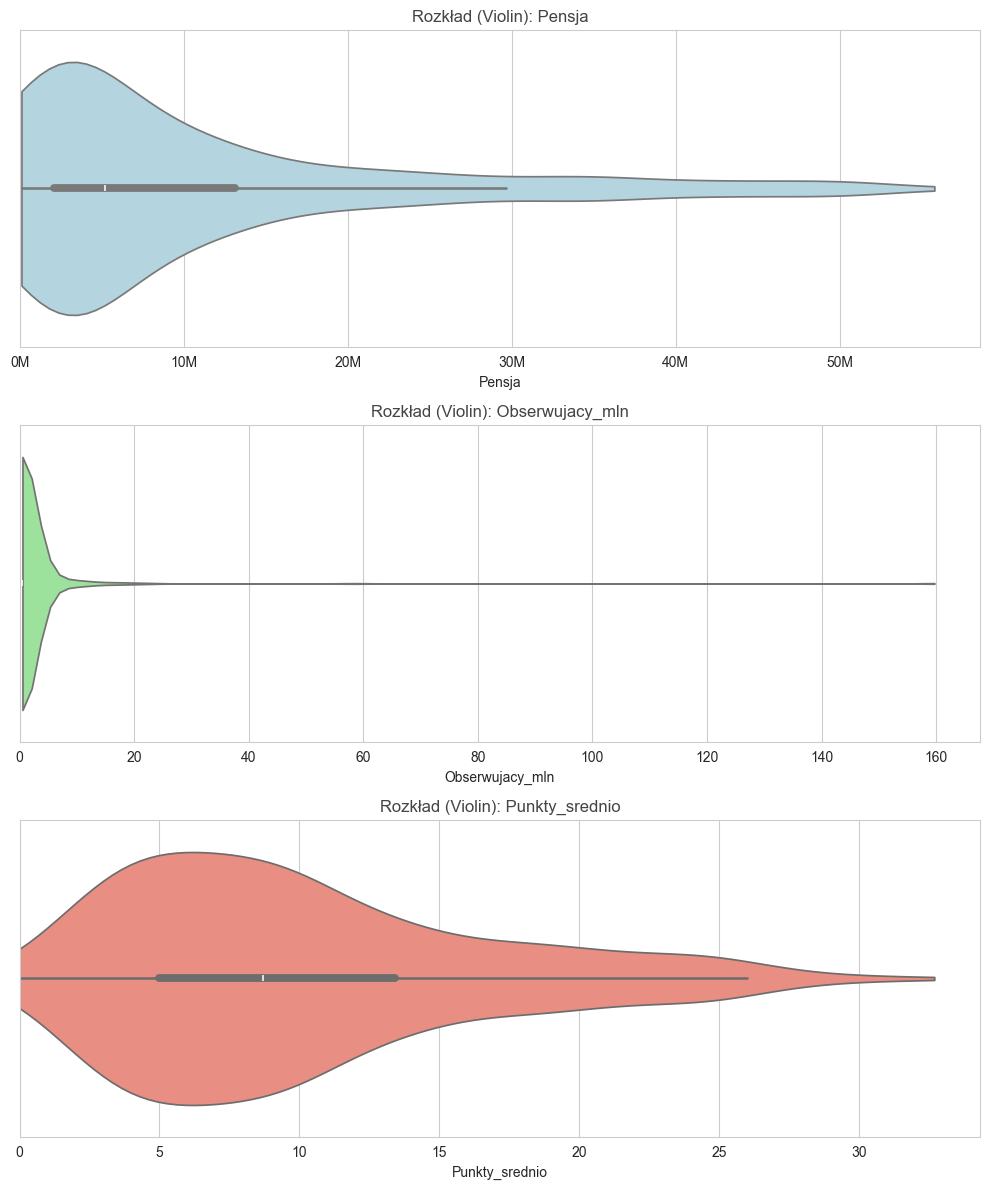

### **Zmienne wskazują na bardziej asymetryczne rozkłady**

## **Kształt danych - Skośność i Kurtoza**

,Skośność,Kurtoza,Opis Skośności,Opis Kurtozy
Obserwujacy_mln,16.350775,304.188694,Prawoskośny,Spiczasty
Koszt_za_punkt,5.457251,40.940494,Prawoskośny,Spiczasty
Blok_srednia,2.520211,11.223198,Prawoskośny,Spiczasty
Skuteczność_proc,0.294932,3.569338,Normalny,Spiczasty
Asysty_srednio,1.531042,2.647542,Prawoskośny,Płaski/Normalny
Obrona_Suma,1.031322,2.286506,Prawoskośny,Płaski/Normalny
Przechwyty_srednia,0.960625,2.038123,Normalny,Płaski/Normalny
Pensja,1.675743,2.037185,Prawoskośny,Płaski/Normalny
Zbiorki_srednia,1.244914,1.837392,Prawoskośny,Płaski/Normalny
Straty_srednio,1.215356,1.341251,Prawoskośny,Płaski/Normalny


In [ ]:

display(Markdown("## **Rozkład zmiennych (Wykresy)**"))

zmienne_do_analizy = ['Pensja', 'Obserwujacy_mln', 'Punkty_srednio']

def interpretacja_statystyk(df):
    stats = pd.DataFrame({
        'Skośność': df.skew(),
        'Kurtoza': df.kurt()
    })
    
    stats['Opis Skośności'] = stats['Skośność'].apply(
        lambda x: "Prawoskośny" if x > 1 else ("Lewoskośny" if x < -1 else "Normalny")
    )
    stats['Opis Kurtozy'] = stats['Kurtoza'].apply(
        lambda x: "Spiczasty" if x > 3 else "Płaski/Normalny"
    )
    
    return stats.sort_values('Kurtoza', ascending=False)

#5.1 BOXPLOT
plt.figure(figsize=(18, 4))
for i, col in enumerate(zmienne_do_analizy):
    plt.subplot(1, 3, i+1)
    sns.boxplot(x=data[col], color='skyblue')
    plt.title(f'Boxplot: {col}')
    if col == 'Pensja': 
        plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x/1e6:.0f}M'))
plt.tight_layout()
plt.show()

#5.2 VIOLINPLOT
fig, axes = plt.subplots(len(zmienne_do_analizy), 1, figsize=(10, 12))
kolory = ['lightblue', 'lightgreen', 'salmon']

for ax, col, kolor in zip(axes, zmienne_do_analizy, kolory):
    
    sns.violinplot(x=data[col], ax=ax, color=kolor, cut=0) 
    
    ax.set_title(f'Rozkład (Violin): {col}')
    
    
    if col == 'Pensja':
        ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x/1e6:.0f}M'))
    
    
    ax.set_xlim(left=0)

plt.tight_layout()
plt.show()

display(Markdown("### **Zmienne wskazują na bardziej asymetryczne rozkłady**"))

#SKOŚNOŚĆ I KURTOZA
display(Markdown("## **Kształt danych - Skośność i Kurtoza**"))
df_num = data.select_dtypes(include=['number'])
raport_stats = interpretacja_statystyk(df_num)
display(raport_stats.style.background_gradient(subset=['Skośność', 'Kurtoza'], cmap='Reds'))

### **6. ANALIZA KORELACJI**

## Analiza Korelacji Pearsona

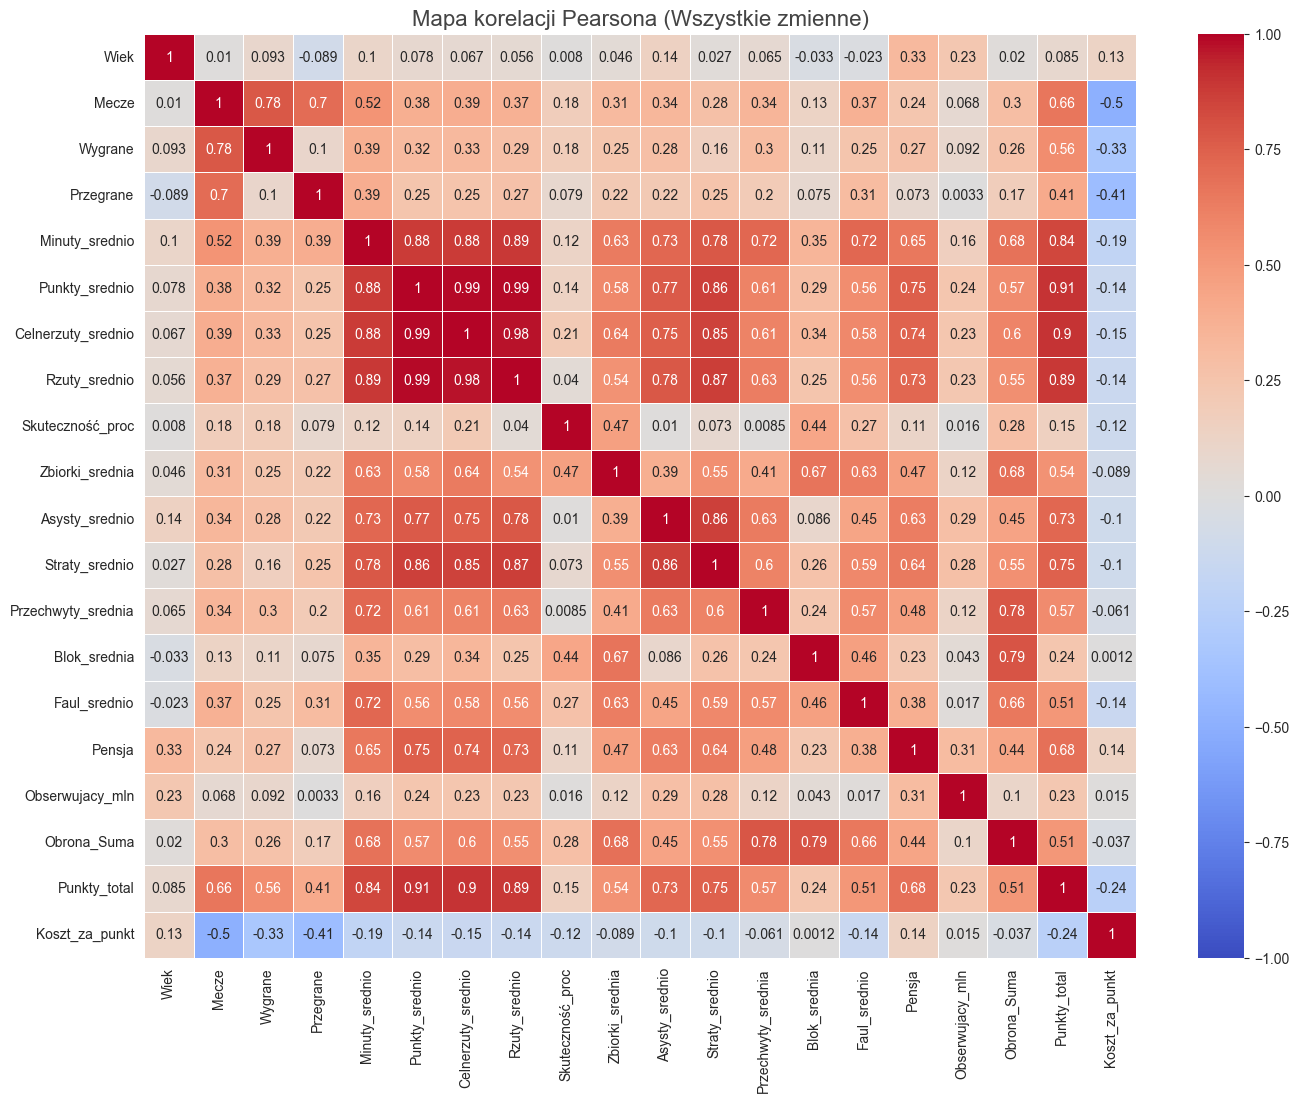

## *Interpretacja: Ze względu na wysoką korelację bezpośrednio powiązanych ze sobą zmiennych, zostały one ograniczone*

### Najsilniejsze korelacje wybranych zmiennych (Pearson)

,,Współczynnik Korelacji
Punkty_srednio,Asysty_srednio,0.772
Pensja,Punkty_srednio,0.752
Asysty_srednio,Przechwyty_srednia,0.633


## *Interpretacja: Zważająć na rozkład zmiennych, zastosowano korelację Spearmana*

## Analiza Korelacji Rangowej (Spearman)

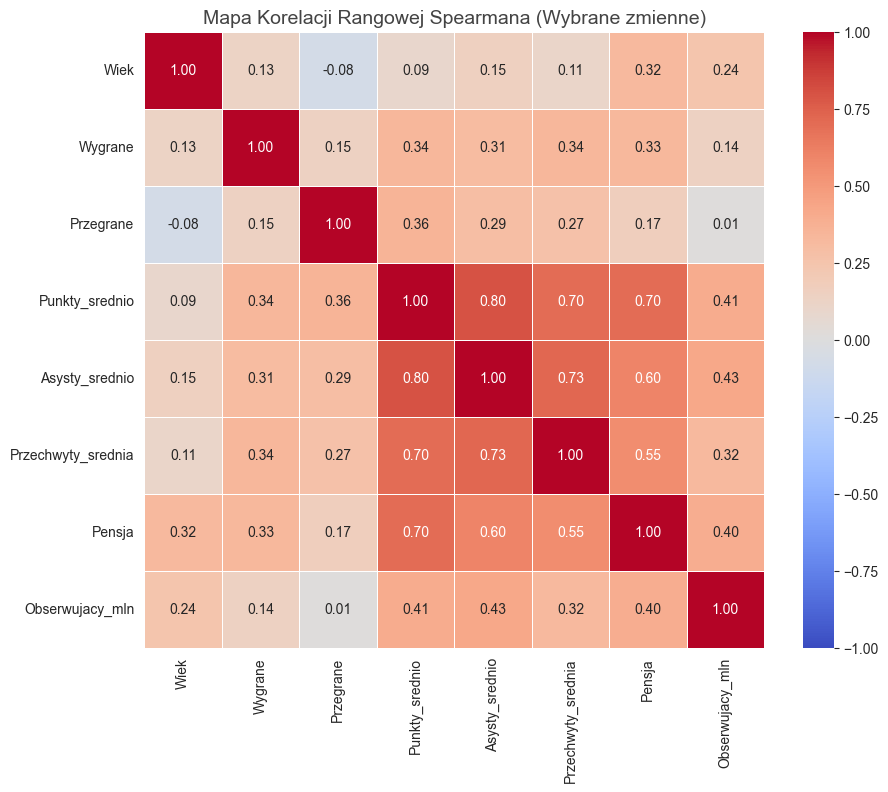

### Najsilniejsze korelacje wybranych zmiennych (Spearman)

,,Współczynnik Korelacji
Punkty_srednio,Asysty_srednio,0.798
Asysty_srednio,Przechwyty_srednia,0.726
Pensja,Punkty_srednio,0.702


In [95]:

display(Markdown("## Analiza Korelacji Pearsona"))

#6.1 KORELACJA PEARSONA (WSZYSTKIE ZMIENNE NUMERYCZNE) - WYKRES
corr_all = data.select_dtypes(include=['number']).corr()

plt.figure(figsize=(16, 12)) 
sns.heatmap(corr_all, 
            annot=True,     
            cmap='coolwarm', 
            linewidths=0.5, 
            vmin=-1, vmax=1)
plt.title('Mapa korelacji Pearsona (Wszystkie zmienne)', fontsize=16)
plt.show()

display(Markdown("## *Interpretacja: Ze względu na wysoką korelację bezpośrednio powiązanych ze sobą zmiennych, zostały one ograniczone*"))

#6.2 KORELACJA PEARSONA (WYBRANE ZMIENNE NUMERYCZNE)- WYKRES
zmienne_korelacja = [
    'Wiek', 'Wygrane', 'Przegrane', 'Punkty_srednio', 
    'Asysty_srednio', 'Przechwyty_srednia', 'Pensja', 'Obserwujacy_mln'
]
subset = data[zmienne_korelacja]

display(Markdown("### Najsilniejsze korelacje wybranych zmiennych (Pearson)"))

#6.3 KORELACJA PEARSONA (WYBRANE ZMIENNE NUMERYCZNE) - TABELA
corr_pearson = subset.corr(method='pearson')

pairs_p = corr_pearson.unstack().sort_values(ascending=False)
top_3_pearson = pairs_p[pairs_p < 1.0].iloc[::2].head(3).to_frame(name='Współczynnik Korelacji')

display(
    top_3_pearson.style
    .format("{:.3f}")
    .background_gradient(cmap='Reds')
    .set_caption("Najsilniejsze zależności liniowe (Pearson)")
)

display(Markdown("## *Interpretacja: Zważająć na rozkład zmiennych, zastosowano korelację Spearmana*"))

#6.4 KORELACJA RANGOWA SPEARMANA (WYBRANE ZMIENNE NUMERYCZNE) - WYKRES 
display(Markdown("## Analiza Korelacji Rangowej (Spearman)"))

corr_spearman = subset.corr(method='spearman')

plt.figure(figsize=(10, 8))
sns.heatmap(corr_spearman, 
            annot=True, 
            cmap='coolwarm', 
            fmt=".2f", 
            linewidths=0.5, 
            vmin=-1, vmax=1)
plt.title('Mapa Korelacji Rangowej Spearmana (Wybrane zmienne)', fontsize=14)
plt.show()

#6.5 KORELACJA RANGOWA SPEARMANA (WYBRANE ZMIENNE NUMERYCZNE) - TABELA 
pairs_s = corr_spearman.unstack().sort_values(ascending=False)
top_3_spearman = pairs_s[pairs_s < 1.0].iloc[::2].head(3).to_frame(name='Współczynnik Korelacji')

display(Markdown("### Najsilniejsze korelacje wybranych zmiennych (Spearman)"))
display(
    top_3_spearman.style
    .format("{:.3f}")
    .background_gradient(cmap='Greens')
    .set_caption("Najsilniejsze zależności rangowe (Rankingowa zgodność)")
)

### **7. WIZUALIZACJA**

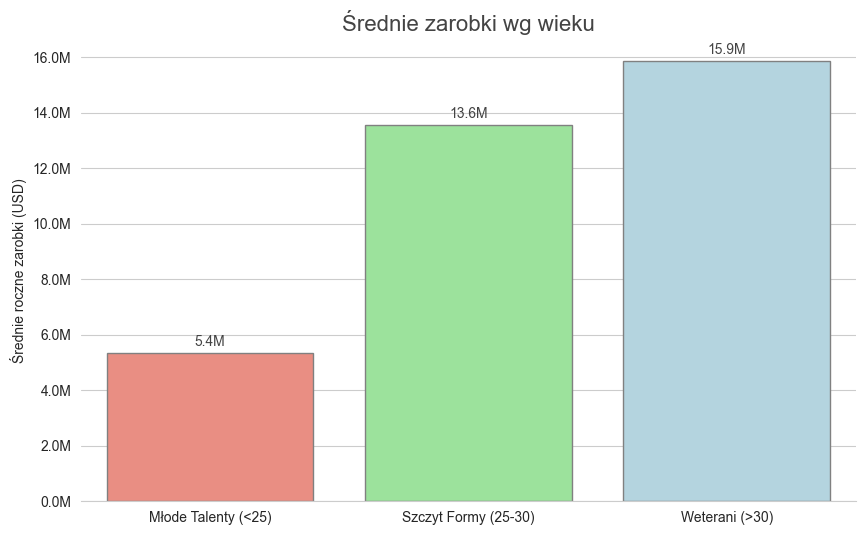

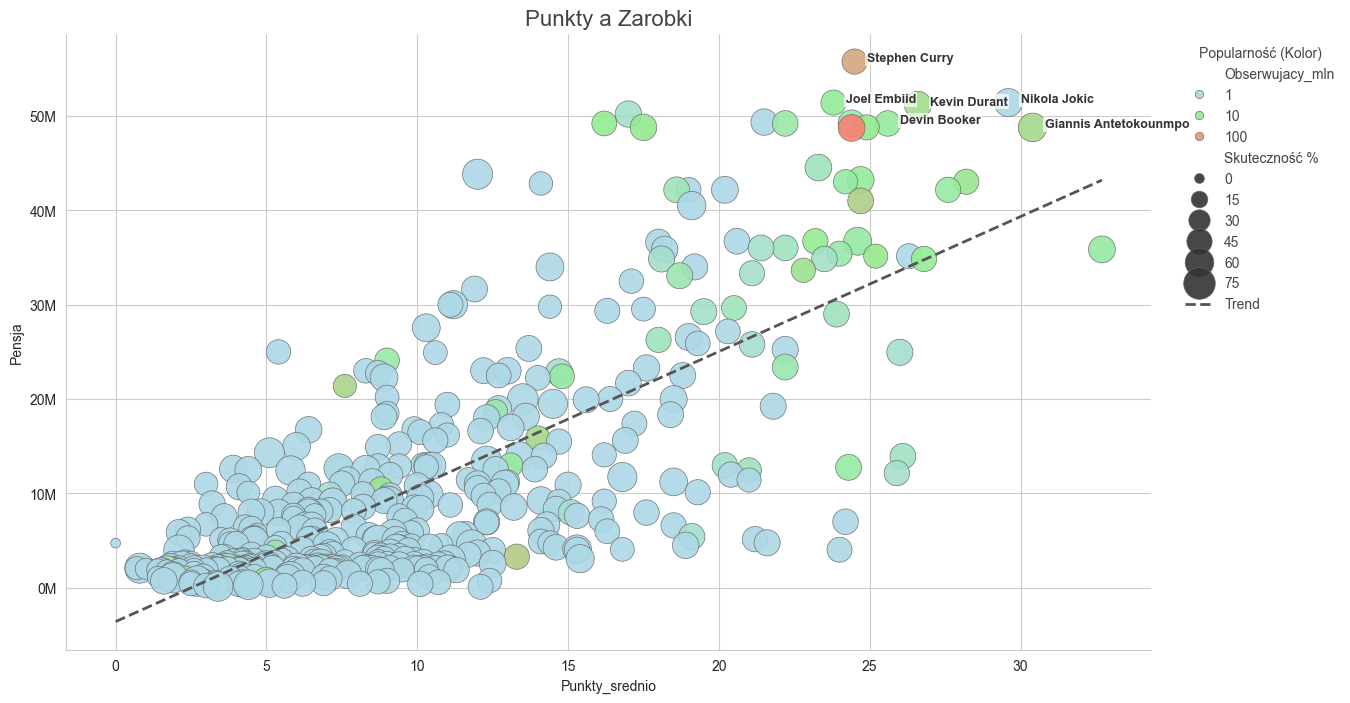

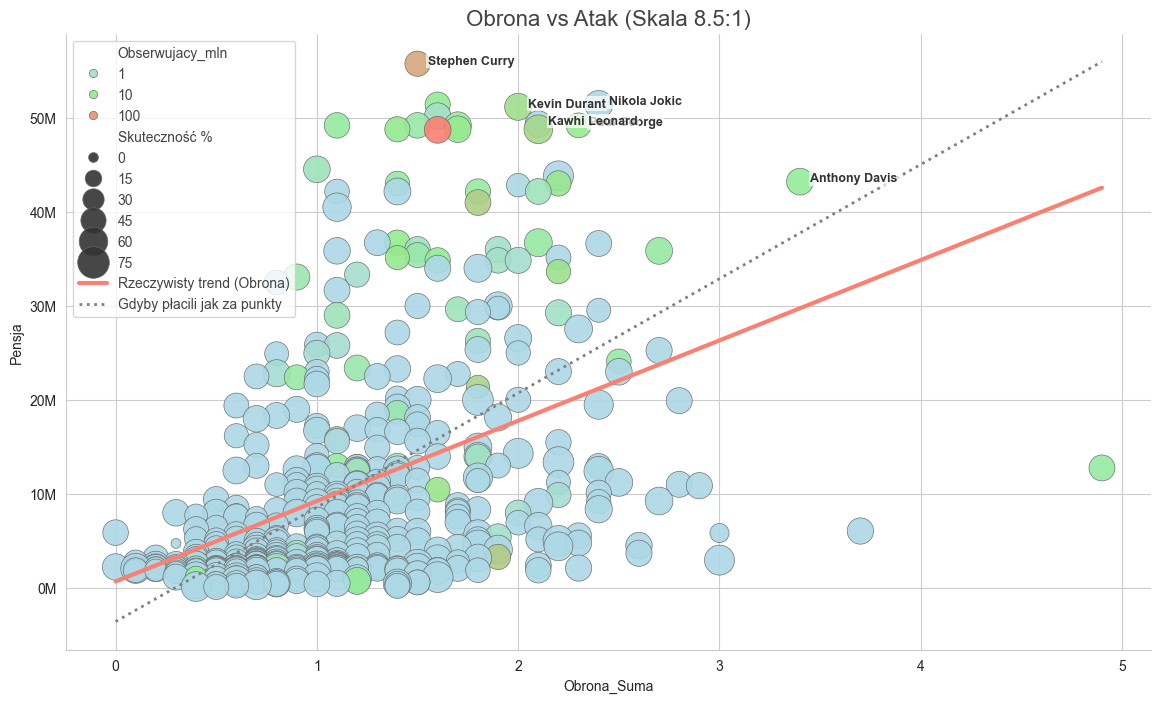

## *Interpretacja: Ofensywa jest bardziej opłacalna niż obrona, pod względem zarobków*

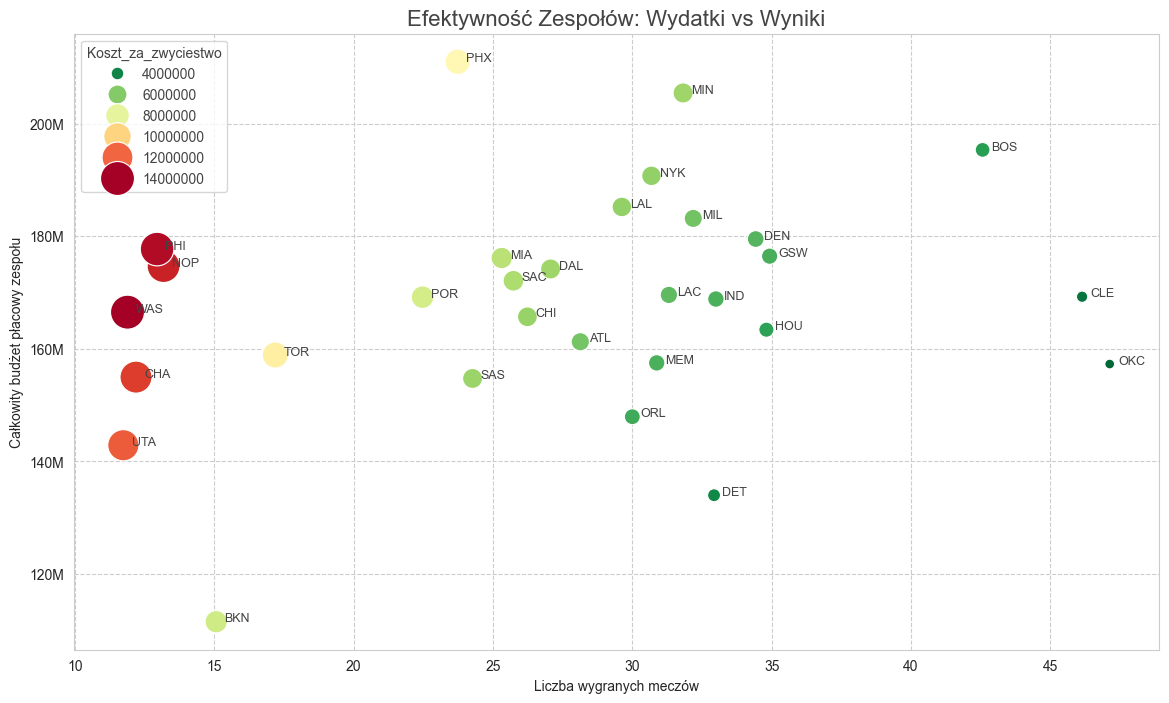

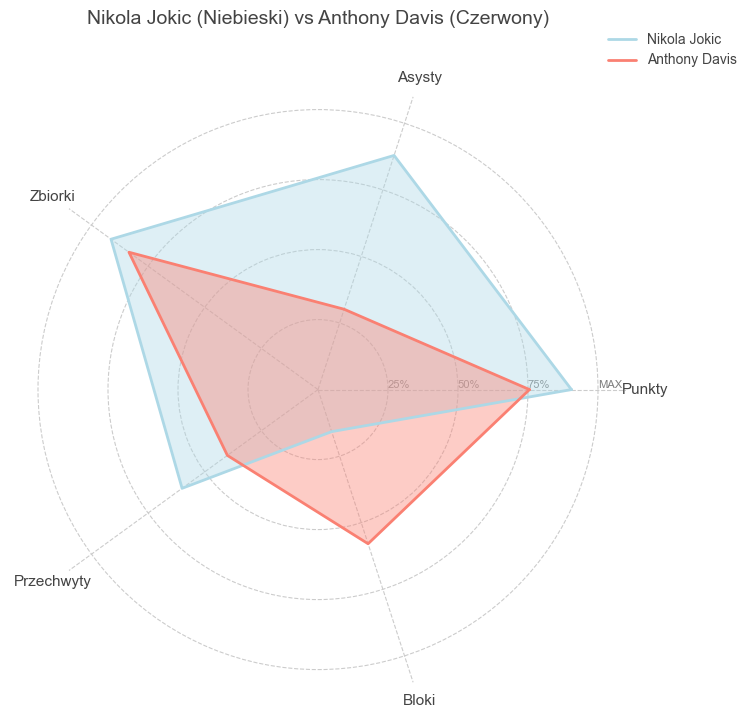

In [ ]:
#7.1 USTAWIENIA WIZUALNE WYKRESÓW
C_BLUE = '#ADD8E6'   
C_GREEN = '#90EE90'  
C_RED = '#FA8072'    

pastel_cmap = LinearSegmentedColormap.from_list("PastelGradient", [C_BLUE, C_GREEN, C_RED])

sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['text.color'] = '#444444'


#7.2 PENSJA A WIEK - WYKRES
data['Grupa_wiekowa'] = data['Wiek'].apply(kategoryzuj_wiek)

plt.figure(figsize=(10, 6))
order_list = ['Młode Talenty (<25)', 'Szczyt Formy (25-30)', 'Weterani (>30)']

ax = sns.barplot(x='Grupa_wiekowa', y='Pensja', data=data, order=order_list, hue='Grupa_wiekowa',
                 palette=[C_BLUE, C_GREEN, C_RED], errorbar=None, edgecolor='grey', legend=False)

plt.title('Średnie zarobki wg wieku', fontsize=16)
plt.xlabel('')
plt.ylabel('Średnie roczne zarobki (USD)')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/1_000_000:.1f}M'))

for container in ax.containers:
    ax.bar_label(container, fmt=lambda x: f'{x/1_000_000:.1f}M', padding=3, color='#444444')

sns.despine(left=True)
plt.show()



#7.3 PENSJA A PUNKTY, PENSJA A OBRONA
#7.3.1 Obliczanie trendów
a_pts, b_pts = np.polyfit(df['Punkty_srednio'], df['Pensja'], 1)
a_def, b_def = np.polyfit(df['Obrona_Suma'], df['Pensja'], 1)
mnoznik = df['Punkty_srednio'].mean() / df['Obrona_Suma'].mean()

style_kwargs = {
    'hue': 'Obserwujacy_mln', 
    'hue_norm': LogNorm(),
    'size': 'Skuteczność %', 
    'sizes': (50, 550),     
    'alpha': 0.9,           
    'palette': pastel_cmap, 
    'data': df,
    'edgecolor': '#666666', 
    'linewidth': 0.5
}

#7.3.2 WYKRES PENSJA A PUNKTY
plt.figure(figsize=(14, 8))
ax1 = sns.scatterplot(x='Punkty_srednio', y='Pensja', **style_kwargs)

x_rng = np.linspace(df['Punkty_srednio'].min(), df['Punkty_srednio'].max(), 100)
plt.plot(x_rng, a_pts * x_rng + b_pts, color='#555555', linestyle='--', linewidth=2, label='Trend')

podpisz_graczy(ax1, 'Punkty_srednio', offset_x=0.4)
sns.despine()
plt.title('Punkty a Zarobki', fontsize=16)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', frameon=False, title="Popularność (Kolor)")
plt.show()

#7.3.3 WYKRES PENSJA A OBRONA
plt.figure(figsize=(14, 8))
ax2 = sns.scatterplot(x='Obrona_Suma', y='Pensja', **style_kwargs)
x_rng_def = np.linspace(df['Obrona_Suma'].min(), df['Obrona_Suma'].max(), 100)

plt.plot(x_rng_def, a_def * x_rng_def + b_def, color=C_RED, lw=3, label='Rzeczywisty trend (Obrona)')
plt.plot(x_rng_def, a_pts * (x_rng_def * mnoznik) + b_pts, color='gray', linestyle=':', lw=2, label='Gdyby płacili jak za punkty')

podpisz_graczy(ax2, 'Obrona_Suma', offset_x=0.05)
sns.despine()
plt.title(f'Obrona vs Atak (Skala {mnoznik:.1f}:1)', fontsize=16)
plt.legend(loc='upper left')
plt.show()

display(Markdown("## *Interpretacja: Ofensywa jest bardziej opłacalna niż obrona, pod względem zarobków*"))

#7.4 EFEKTYWNOŚĆ ZESPOŁÓW - WYKRES
team_stats = data.groupby('Zespół').agg({
    'Pensja': 'sum',    
    'Wygrane': 'mean'   
}).reset_index()


team_stats['Koszt_za_zwyciestwo'] = team_stats['Pensja'] / team_stats['Wygrane']

plt.figure(figsize=(14, 8))


sns.scatterplot(data=team_stats, x='Wygrane', y='Pensja', size='Koszt_za_zwyciestwo', sizes=(50, 600), hue='Koszt_za_zwyciestwo', palette='RdYlGn_r')


for i in range(team_stats.shape[0]):
    plt.text(
        team_stats.Wygrane.iloc[i]+0.3, 
        team_stats.Pensja.iloc[i], 
        team_stats.Zespół.iloc[i], 
        fontsize=9
    )

plt.title('Efektywność Zespołów: Wydatki vs Wyniki', fontsize=16)
plt.xlabel('Liczba wygranych meczów')
plt.ylabel('Całkowity budżet płacowy zespołu')
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/1_000_000:.0f}M'))
plt.grid(True, linestyle='--')
plt.show()


#7.5 PORÓWNANIE DWÓCH GRACZY - WYKRES RADAROWY
gracz_1 = data[data['Punkty_srednio'] > 25].iloc[0]
gracz_2 = data[data['Blok_srednia'] > 1.5].iloc[0]
labels = ['Punkty', 'Asysty', 'Zbiorki', 'Przechwyty', 'Bloki'] # Skrócone nazwy
num_vars = len(labels)
values_1 = [normalize(gracz_1[c], c) for c in ['Punkty_srednio', 'Asysty_srednio', 'Zbiorki_srednia', 'Przechwyty_srednia', 'Blok_srednia']] + [normalize(gracz_1['Punkty_srednio'], 'Punkty_srednio')]
values_2 = [normalize(gracz_2[c], c) for c in ['Punkty_srednio', 'Asysty_srednio', 'Zbiorki_srednia', 'Przechwyty_srednia', 'Blok_srednia']] + [normalize(gracz_2['Punkty_srednio'], 'Punkty_srednio')]
angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)] + [0]

plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)

ax.plot(angles, values_1, linewidth=2, linestyle='solid', label=gracz_1['Zawodnik'], color=C_BLUE)
ax.fill(angles, values_1, C_BLUE, alpha=0.4)

ax.plot(angles, values_2, linewidth=2, linestyle='solid', label=gracz_2['Zawodnik'], color=C_RED)
ax.fill(angles, values_2, C_RED, alpha=0.4)

plt.xticks(angles[:-1], labels, color='#444444', size=11)
ax.set_rlabel_position(0)
plt.yticks([0.25, 0.5, 0.75, 1.0], ["25%","50%","75%","MAX"], color="grey", size=8)
plt.ylim(0, 1.1)
ax.spines['polar'].set_visible(False)
plt.grid(color='#CCCCCC', linestyle='--')

plt.title(f"{gracz_1['Zawodnik']} (Niebieski) vs {gracz_2['Zawodnik']} (Czerwony)", y=1.08, fontsize=14)
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1), frameon=False)
plt.show()

### **8. WNIOSKOWANIE STATYSTYCZNE**

## Regresja liniowa

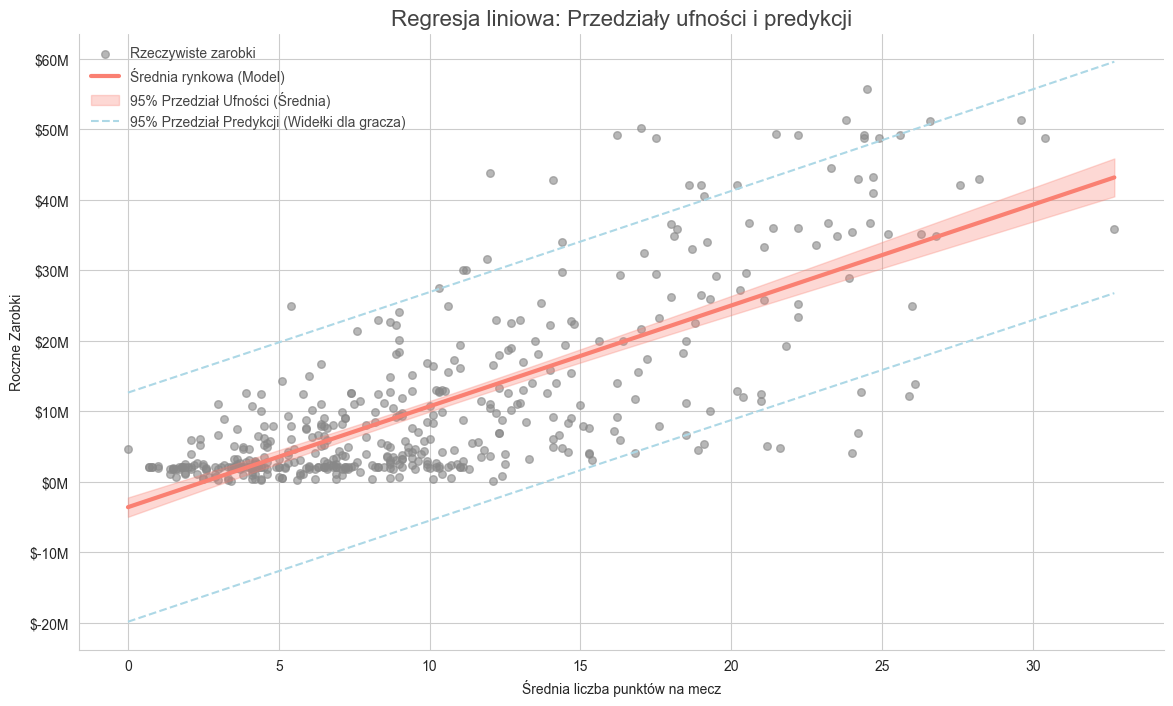

## Model OLS

**Dopasowanie modelu (R²):** `66.04%` zmienności zarobków jest wyjaśniona przez te dane.

,Współczynnik ($),P-value,Siła wpływu
Wiek,"$615,179.64",0.0000,Bardzo silna
Punkty_srednio,"$2,350,125.24",0.0000,Bardzo silna
Obserwujacy_mln,"$110,658.13",0.0165,Istotna
Przegrane,"$-49,850.70",0.0272,Istotna
Mecze,"$-28,021.72",0.0524,Słaba
Zbiorki_srednia,"$559,215.76",0.0604,Słaba
Asysty_srednio,"$717,456.19",0.1092,Brak związku
Rzuty_srednio,"$-973,383.94",0.1746,Brak związku
Wygrane,"$21,828.98",0.3036,Brak związku
Straty_srednio,"$-1,329,044.01",0.3038,Brak związku


Zawodnik rzucający **20 pkt** powinien zarabiać ok. **$25.0M**

## Regresja lasu losowego (Random Forest)

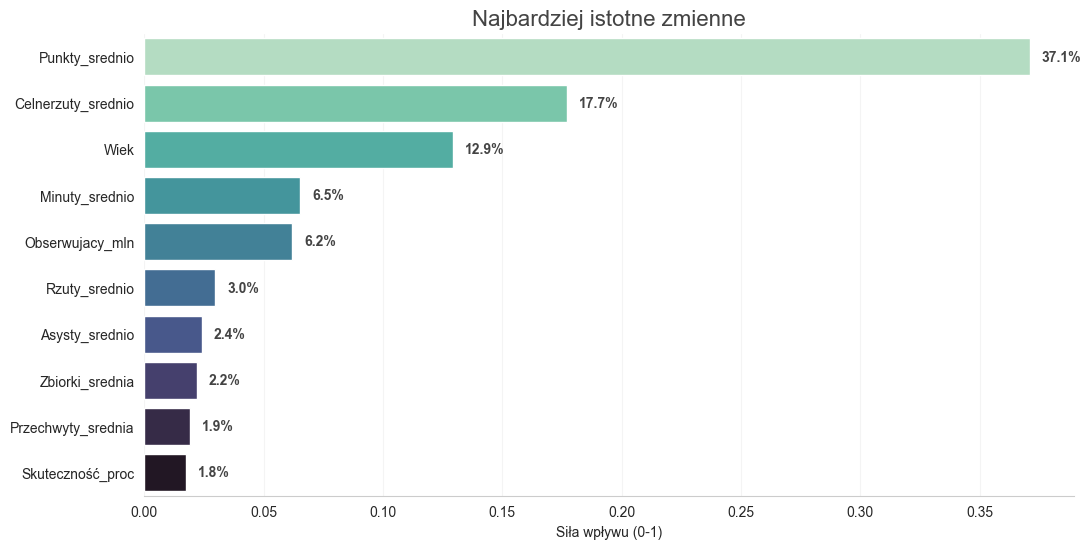

**Średni błąd modelu (MAE):** Model myli się średnio o **$4.42M** przy wycenie zawodnika.

In [85]:

#8.1 USTAWIENIA WIZUALNE WYKRESÓW
PASTEL_BLUE = '#ADD8E6'
PASTEL_GREEN = '#90EE90'
PASTEL_RED = '#FA8072'
PASTEL_PURPLE = '#B39EB5'

# PRZEDZIAŁ UFNOŚCI I PREDYKCJI W REGRESJI
display(Markdown("## Regresja liniowa"))

#8.2 PRZEDZIAŁ UFNOŚCI I PREDYKCJI W REGRESJI
df_reg = data[['Punkty_srednio', 'Pensja']].dropna()
X = df_reg['Punkty_srednio']
y = df_reg['Pensja']
X_const = sm.add_constant(X)

#8.2.1 PROSTY MODEL REGRESJI (OLS)
model_simple = sm.OLS(y, X_const).fit()

x_range = np.linspace(X.min(), X.max(), 100)
x_range_const = sm.add_constant(x_range)
pred_frame = model_simple.get_prediction(x_range_const).summary_frame(alpha=0.05)

#8.2.2 WYKRES Z PRZEDZIAŁAMI UFNOŚCI I PREDYKCJI
plt.figure(figsize=(14, 8))

plt.scatter(X, y, alpha=0.6, color='#888888', label='Rzeczywiste zarobki', s=30)

plt.plot(x_range, pred_frame['mean'], color=PASTEL_RED, linewidth=3, label='Średnia rynkowa (Model)')

plt.fill_between(x_range, pred_frame['mean_ci_lower'], pred_frame['mean_ci_upper'], 
                 color=PASTEL_RED, alpha=0.3, label='95% Przedział Ufności (Średnia)')

plt.plot(x_range, pred_frame['obs_ci_lower'], color=PASTEL_BLUE, linestyle='--', linewidth=1.5, label='95% Przedział Predykcji (Widełki dla gracza)')
plt.plot(x_range, pred_frame['obs_ci_upper'], color=PASTEL_BLUE, linestyle='--', linewidth=1.5)

plt.title('Regresja liniowa: Przedziały ufności i predykcji', fontsize=16)
plt.xlabel('Średnia liczba punktów na mecz')
plt.ylabel('Roczne Zarobki')
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'${x/1_000_000:.0f}M'))
plt.legend(loc='upper left', frameon=False)
sns.despine()
plt.show()



#8.3 MODEL REGRESJI WIELOKROTNEJ (OLS)
df_ols = data.select_dtypes(include=['number']).dropna()

y = df_ols['Pensja']

kolumny_do_usuniecia = ['Pensja', 'Koszt_za_punkt', 'Punkty_total', 'Obrona_Suma']
kolumny_do_usuniecia = [c for c in kolumny_do_usuniecia if c in df_ols.columns]

X = df_ols.drop(columns=kolumny_do_usuniecia)
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()


wyniki = pd.DataFrame({
    'Współczynnik ($)': model.params,    
    'P-value': model.pvalues             
})

def ocen_istotnosc(p):
    if p < 0.01: return 'Bardzo silna'
    elif p < 0.05: return 'Istotna'
    elif p < 0.1: return 'Słaba'
    else: return 'Brak związku'

wyniki['Siła wpływu'] = wyniki['P-value'].apply(ocen_istotnosc)

if 'const' in wyniki.index:
    wyniki = wyniki.drop('const')

wyniki = wyniki.sort_values(by='P-value')

display(Markdown(f"## Model OLS"))
display(Markdown(f"**Dopasowanie modelu (R²):** `{model.rsquared:.2%}` zmienności zarobków jest wyjaśniona przez te dane."))

display(
    wyniki.style
    .format({
        'Współczynnik ($)': '${:,.2f}',
        'P-value': '{:.4f}'
    })
    # Kolorujemy P-value: Zielony = Dobrze (małe p-value), Czerwony = Źle (duże p-value)
    .background_gradient(subset=['P-value'], cmap='RdYlGn_r', vmin=0, vmax=0.1)
)

#8.4 SYMULACJA
pts_test = 20
pred_20 = model_simple.get_prediction([1, pts_test]).summary_frame(alpha=0.05)
display(Markdown(f"Zawodnik rzucający **{pts_test} pkt** powinien zarabiać ok. **${pred_20['mean'][0]/1e6:.1f}M**"))


#8.5 RANDOM FOREST
display(Markdown("## Regresja lasu losowego (Random Forest)"))

X_rf = df_ols.drop(columns=cols_drop_ols).dropna()
y_rf = df_ols['Pensja'][X_rf.index]

X_train, X_test, y_train, y_test = train_test_split(X_rf, y_rf, test_size=0.2, random_state=42)

#8.5.1 MODEL
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)

#8.5.2 WIZUALIZACJA NAJWAŻNIEJSZYCH ZMIENNYCH
importances = pd.DataFrame({'Zmienna': X_rf.columns, 'Waga': rf.feature_importances_})
importances = importances.sort_values(by='Waga', ascending=False).head(10)

plt.figure(figsize=(12, 6))
ax = sns.barplot(x='Waga', y='Zmienna', data=importances, hue='Zmienna', palette='mako_r', legend=False)

plt.title('Najbardziej istotne zmienne', fontsize=16)
plt.xlabel('Siła wpływu (0-1)')
plt.ylabel('')
plt.grid(axis='x', alpha=0.2)
sns.despine(left=True)

for i, v in enumerate(importances['Waga']):
    plt.text(v + 0.005, i, f'{v:.1%}', va='center', fontsize=10, fontweight='bold', color='#444444')

plt.show()

display(Markdown(f"**Średni błąd modelu (MAE):** Model myli się średnio o **${mae/1e6:.2f}M** przy wycenie zawodnika."))

# **9. WNIOSKI**  

**"Punkty to pieniądz"** – Skuteczność ofensywna jest kluczowa. Zarówno model regresji liniowej (OLS), jak i metoda Random Forest wskazują, że średnia liczba punktów na mecz jest  najważniejszym czynnikiem determinującym zarobki.W modelu  
1. Model **Random Forest** obliczył, że punkty odpowiadają aż za **37.1%** ważności modelu.  
2. Model **OLS** wyliczył, że każdy dodatkowy punkt średnio na mecz przekłada się na wzrost rocznej pensji o około 2,35 mln USD (przy założeniu niezmienności innych cech).  
3. Korelacja rangowa **Spearmana** potwierdza silny związek pensji z punktami (0.702).  

**Liczba obserwujących** nie przekłada się bezpośrednio na wielkość zarobków, wbrew hipotezie badawczej. Zmienna ta ma marginalne znaczenie dla wysokości kontraktu klubowego.  
1. W modelu Random Forest popularność ma tylko 6.2% wpływu na wynik
2. Model OLS wykazał istotność statystyczną, natomiast niski wpływ: 1 milion obserwujących podnosi pensję "tylko" o 110 tys. USD. Dla porównania jeden punkt na boisku jest wart ponad 20 razy więcej.

**Obrona** jest finansowo niedoceniana. Analiza wykazała istotną dysproporcję w wycenie zadań na boisku.
1. W modelu OLS zmienne "defensywne" takie jak Bloki (p-value 0.966) oraz Przechwyty (p-value 0.370) okazały się statystycznie nieistotne. 
2. Wykres (Obrona vs Pensja) pokazuje, że linia trendu dla obrony jest znacznie bardziej płaska niż hipotetyczna linia dla punktów. 

**Doświadczenie popłaca**. Starszy zawodnik (weteran) zarabia średnio o 615 tys. USD więcej za każdy rok doświadczenia.
1. Wiek zawodnika jest trzecim najważniejszym czynnikiem w modelu Random Forest (12.9% ważności) 
2. Jest istotnym w modelu OLS (p-value 0.000).

**Ograniczenia modelu** - Zbudowane modele wyjaśniają około 66% (R²) zmienności zarobków. Oznacza to, że boiskowe statystyki oraz wiek tłumaczą dwie trzecie pensji zawodnika. Pozostałe 34% zależy od czynników, które nie zostały ujęte w zbiorze danych